# BLE Proximity Experiment - Multi-Layered Perceptron Regressor
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [2]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

Using TensorFlow backend.
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarn

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [3]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [4]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [5]:
dataset = load_file('../../dataset_train_university.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,4.5,-86,-86.000000,Public,4.5
1,0.0,4.5,-84,-85.000000,Public,4.5
2,0.0,4.5,-83,-84.333333,Public,4.5
3,0.0,4.5,-84,-84.250000,Public,4.5
4,0.0,4.5,-92,-85.800000,Public,4.5
...,...,...,...,...,...,...
3672,0.0,0.0,-57,-56.814815,Personal,0.0
3673,0.0,0.0,-56,-56.785714,Personal,0.0
3674,0.0,0.0,-56,-56.758621,Personal,0.0
3675,0.0,0.0,-56,-56.733333,Personal,0.0


(3677, 6)

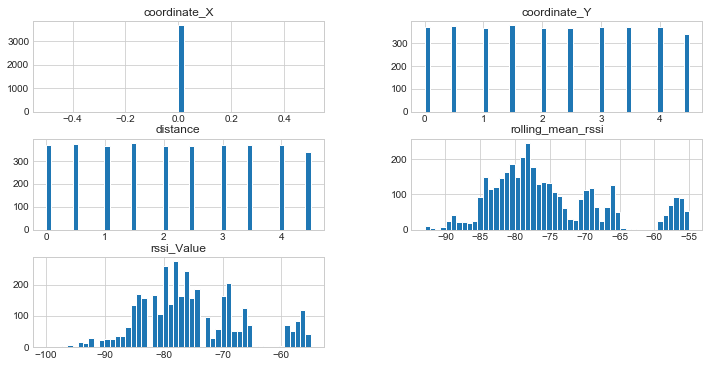

In [6]:
test_dataset = load_file('../../dataset_test_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | BIG DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,Personal,0.0
1,0.0,0.0,-46,-46.500000,Personal,0.0
2,0.0,0.0,-46,-46.333333,Personal,0.0
3,0.0,0.0,-47,-46.500000,Personal,0.0
4,0.0,0.0,-47,-46.600000,Personal,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,Social,3.5
12471,0.0,3.5,-87,-84.684211,Social,3.5
12472,0.0,3.5,-87,-84.800000,Social,3.5
12473,0.0,3.5,-87,-84.904762,Social,3.5


(12475, 6)

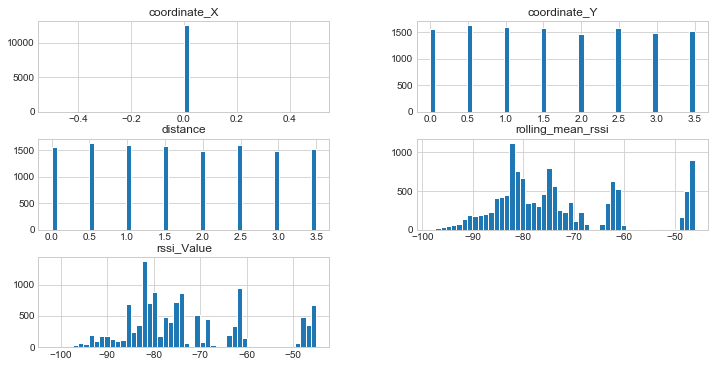

In [7]:
test_dataset_home_big = load_file('../../dataset_test_home_big.csv')
positions = test_dataset_home_big['coordinate_Y']
test_dataset_home_big['distance'] = positions
replace_features_nan(test_dataset_home_big)
display(test_dataset_home_big)
display(test_dataset_home_big.shape)
test_dataset_home_big.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,Personal,0.0
1,0.0,0.0,-44,-44.000000,Personal,0.0
2,0.0,0.0,-44,-44.000000,Personal,0.0
3,0.0,0.0,-44,-44.000000,Personal,0.0
4,0.0,0.0,-45,-44.200000,Personal,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,Social,3.5
2280,0.0,3.5,-85,-84.000000,Social,3.5
2281,0.0,3.5,-85,-84.050000,Social,3.5
2282,0.0,3.5,-92,-84.428571,Social,3.5


(2284, 6)

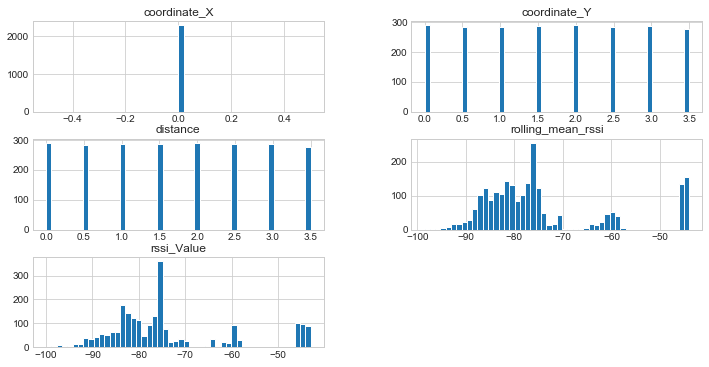

In [8]:
test_dataset_home_small = load_file('../../dataset_test_home.csv')
positions = test_dataset_home_small['coordinate_Y']
test_dataset_home_small['distance'] = positions
replace_features_nan(test_dataset_home_small)
display(test_dataset_home_small)
display(test_dataset_home_small.shape)
test_dataset_home_small.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET ASUS)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,Personal,0.0
1,0.0,0.0,-50,-50.000000,Personal,0.0
2,0.0,0.0,-53,-51.000000,Personal,0.0
3,0.0,0.0,-51,-51.000000,Personal,0.0
4,0.0,0.0,-53,-53.000000,Personal,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,Social,3.5
411,0.0,3.5,-88,-84.500000,Social,3.5
412,0.0,3.5,-84,-84.428571,Social,3.5
413,0.0,3.5,-83,-84.250000,Social,3.5


(415, 6)

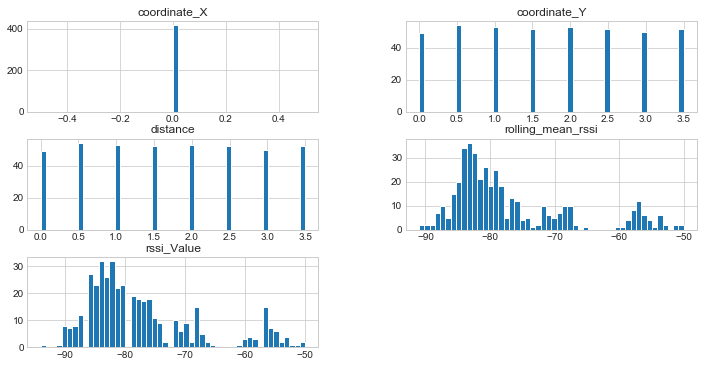

In [9]:
test_dataset_home_asus = load_file('../../dataset_test_home_asus.csv')
positions = test_dataset_home_asus['coordinate_Y']
test_dataset_home_asus['distance'] = positions
replace_features_nan(test_dataset_home_asus)
display(test_dataset_home_asus)
display(test_dataset_home_asus.shape)
test_dataset_home_asus.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [10]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24834 entries, 0 to 24833
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       24834 non-null  float64
 1   coordinate_Y       24834 non-null  float64
 2   rssi_Value         24834 non-null  int64  
 3   rolling_mean_rssi  24834 non-null  float64
 4   zone               24834 non-null  object 
 5   distance           24834 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [11]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,24834.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
coordinate_Y,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5
rssi_Value,24834.0,-76.687243,11.255077,-102.0,-84.000000,-78.0,-73.000000,-46.0
rolling_mean_rssi,24834.0,-76.677952,10.969519,-99.0,-83.666667,-78.5,-73.767308,-46.0
distance,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5


### % of Missing Values

In [12]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [13]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

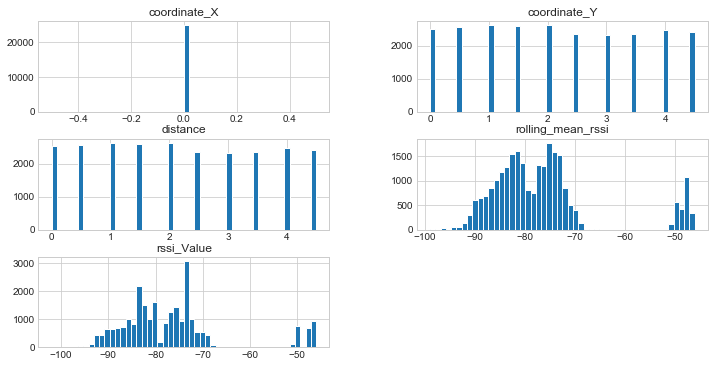

In [14]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Distance
Graphical display of the distances beacon/smartphone scanned in the experiment

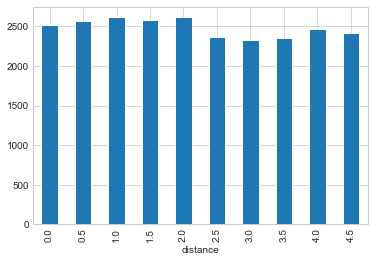

In [15]:
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

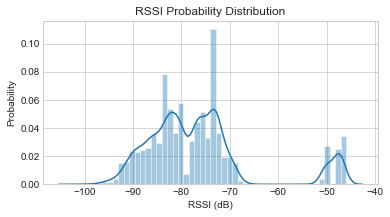

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

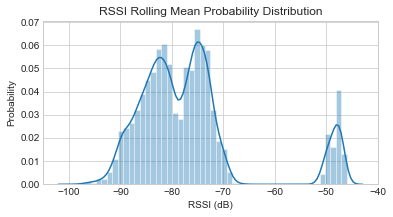

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

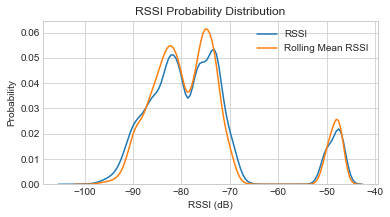

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

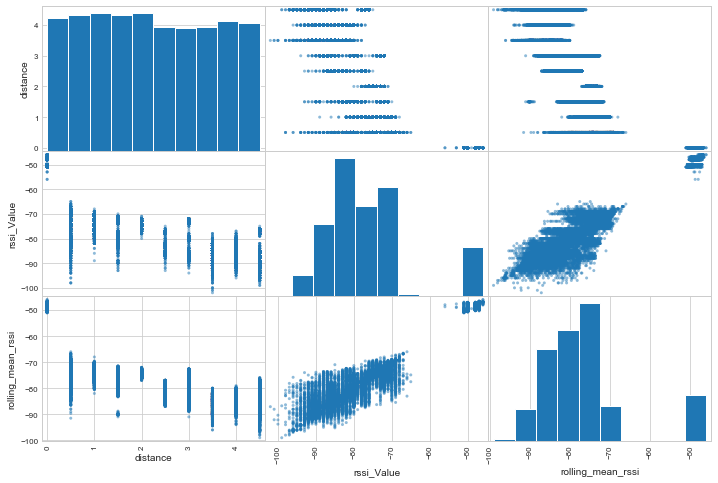

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_big,'rssi_Value')
compute_data_cleaning(test_dataset_home_big,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_small,'rssi_Value')
compute_data_cleaning(test_dataset_home_small,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_asus,'rssi_Value')
compute_data_cleaning(test_dataset_home_asus,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [23]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [24]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed

Previous Categorical Data


,zone
0,Public
1,Public
2,Public
3,Public
4,Public
...,...
3672,Personal
3673,Personal
3674,Personal
3675,Personal


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
categorical_zone = test_dataset_home_big[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_big['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
12470,Social
12471,Social
12472,Social
12473,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
categorical_zone = test_dataset_home_small[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_small['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
2279,Social
2280,Social
2281,Social
2282,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
categorical_zone = test_dataset_home_asus[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_asus['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
410,Social
411,Social
412,Social
413,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Initialize Training Data
Training Data intialization for predictions purposes

In [29]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)
default_groups = dataset['labels'].values.reshape(-1,1)

(24834, 1)

(24834, 1)

(24834, 2)

In [30]:
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
display(train_Y.shape)

(24834, 1)

In [31]:
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-48.351984,-48.325565
0.5,-75.304314,-75.253245
1.0,-74.156908,-74.155786
1.5,-78.266151,-78.279493
2.0,-74.711171,-74.732949
2.5,-82.396866,-82.373984
3.0,-79.297379,-79.557064
3.5,-86.335602,-86.250861
4.0,-84.817666,-84.750632


### Plot Training Data
Graphical Display of the observations in the dataset

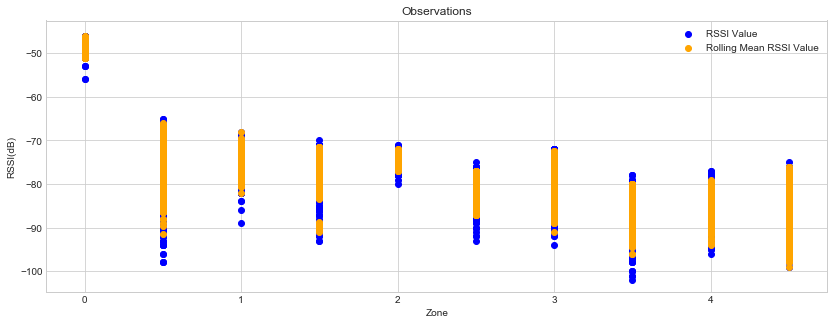

In [32]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [33]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(3677, 1)

(3677, 1)

(3677, 2)

In [34]:
test_Y = pd.DataFrame(test_dataset['distance']).values.reshape(-1,1)
display(test_Y.shape)

(3677, 1)

In [35]:
data_plot_means = test_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-57.010811,-56.935533
0.5,-67.061170,-66.866788
1.0,-75.950685,-76.102343
1.5,-74.568783,-74.328086
2.0,-79.493151,-79.722828
2.5,-76.904891,-76.593561
3.0,-79.255376,-79.142332
3.5,-81.024194,-80.634009
4.0,-80.708108,-80.924987


In [36]:
test_X_rssi_home_big = pd.DataFrame(test_dataset_home_big['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_big.shape)
test_X_rolling_mean_home_big = pd.DataFrame(test_dataset_home_big['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_big.shape)
test_combination_features_X_home_big = test_dataset_home_big[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_big.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [37]:
test_Y_home_big = pd.DataFrame(test_dataset_home_big['distance']).values.reshape(-1,1)
display(test_Y_home_big .shape)

(12475, 1)

In [38]:
data_plot_means = test_dataset_home_big.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-60.626277,-60.688594
Social,-81.402474,-81.424138


In [39]:
test_X_rssi_home_small = pd.DataFrame(test_dataset_home_small['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_small.shape)
test_X_rolling_mean_home_small = pd.DataFrame(test_dataset_home_small['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_small.shape)
test_combination_features_X_home_small = test_dataset_home_small[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_small.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [40]:
test_Y_home_small = pd.DataFrame(test_dataset_home_small['distance']).values.reshape(-1,1)
display(test_Y_home_small .shape)

(2284, 1)

In [41]:
data_plot_means = test_dataset_home_small.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-63.987165,-64.275969
Social,-80.535389,-80.579521


In [42]:
test_X_rssi_home_asus = pd.DataFrame(test_dataset_home_asus['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_asus.shape)
test_X_rolling_mean_home_asus = pd.DataFrame(test_dataset_home_asus['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_asus.shape)
test_combination_features_X_home_asus = test_dataset_home_asus[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_asus.shape)

(415, 1)

(415, 1)

(415, 2)

In [43]:
test_Y_home_asus = pd.DataFrame(test_dataset_home_asus['distance']).values.reshape(-1,1)
display(test_Y_home_small .shape)

(2284, 1)

In [44]:
data_plot_means = test_dataset_home_asus.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-69.205128,-69.220368
Social,-82.181467,-82.010114


### Plot Test Data

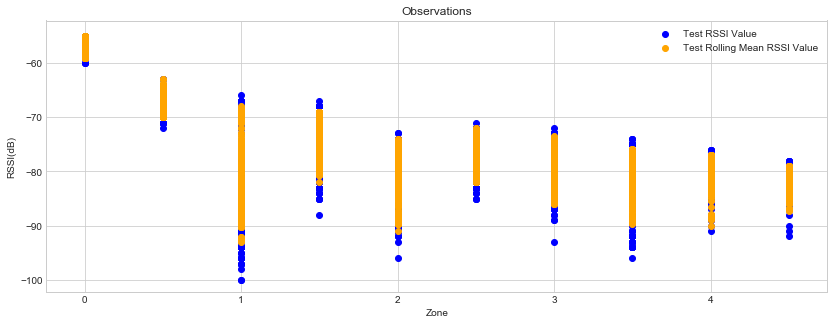

In [45]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['distance'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['distance'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

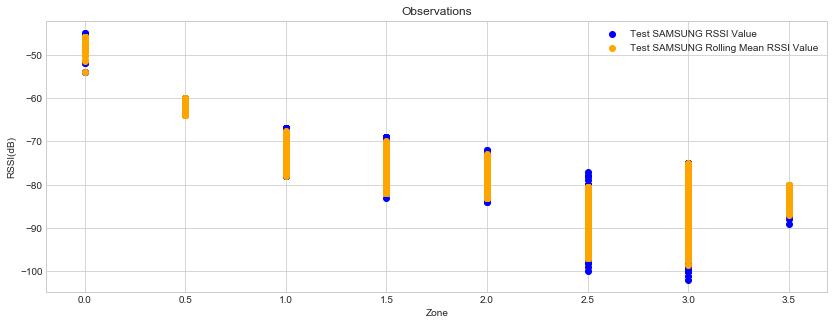

In [46]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_big['distance'],test_dataset_home_big['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_big['distance'],test_dataset_home_big['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

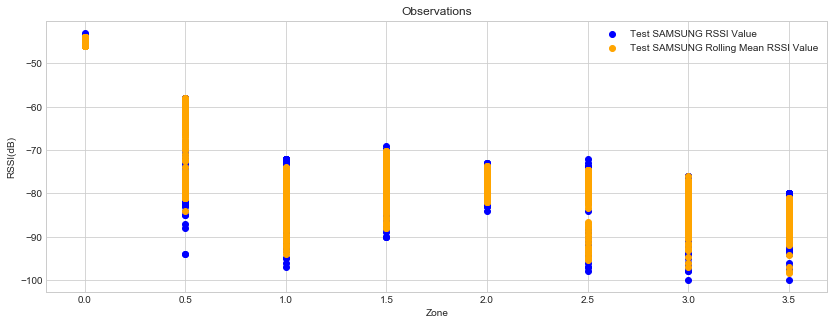

In [47]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_small['distance'],test_dataset_home_small['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_small['distance'],test_dataset_home_small['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

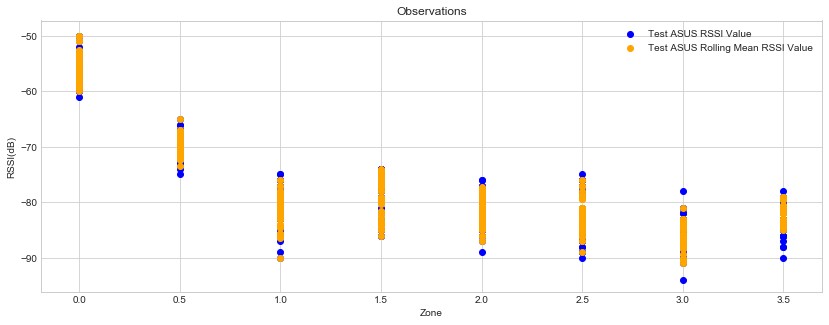

In [48]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_asus['distance'],test_dataset_home_asus['rssi_Value'],label='Test ASUS RSSI Value',color='blue')
plt.scatter(test_dataset_home_asus['distance'],test_dataset_home_asus['rolling_mean_rssi'],label='Test ASUS Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [49]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Batch size of samples
batch_size = [10, 20, 40, 60, 80, 100]
# Epochs 
epochs = [10, 50, 100]
# Optimization function
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# Learning Rate - only used with SGD optimizer
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# Momentum - only used with SGD optimizer
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# Number of neurons in a hidden layer
neurons = [100,300,400,500,600]

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [50]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.16321038, 0.83678962])

rolling_mean_rssi    0.83679
rssi_Value           0.16321
dtype: float64

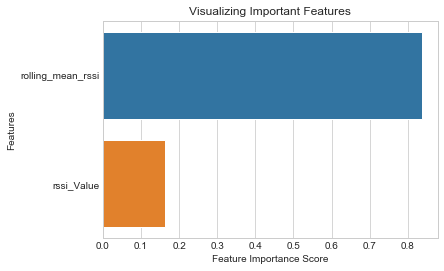

In [51]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestRegressor()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - MLP Regression Model
Experiments with MLP algorithm

In [52]:
num_neurons_basic = 180
print("Default number of neurons: " + str(num_neurons_basic))
# Function to create model, required for KerasRegressor
def create_model(dim=2,num_neurons=num_neurons_basic,activation ='relu',optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(num_neurons,input_dim=dim,activation=activation))
    model.add(Dense(num_neurons,activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['accuracy','mean_absolute_error'])
    return model
model = create_model()
display(model.summary())

Default number of neurons: 180
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               540       
_________________________________________________________________
dense_2 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 181       
Total params: 33,301
Trainable params: 33,301
Non-trainable params: 0
_________________________________________________________________


None

In [53]:
def compute_MLP_Regressor(flag=0,dim=2,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,batch_size=10,epochs=50,verbose=0,num_neurons_param=180,
                          optimizer_func='adam',activation_func='relu'):
    keras_regressor = KerasRegressor(build_fn=create_model,dim=dim,epochs=epochs,num_neurons=num_neurons_param,
                                     optimizer=optimizer_func,activation=activation_func,batch_size=batch_size,verbose=verbose)
    seed = 7
    np.random.seed(seed)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,keras_regressor)
    else:
        main_estimator = keras_regressor
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        print("Cross Validation Activated. CV = " + str(cross_validation))
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)

#### Check Training model with no cross validation
Use MLP Regressor to check the results on the training data alone

Instructions for updating:
Use tf.cast instead.


,Actual,Predicted
0,0.0,-0.013727
1,0.0,-0.013727
2,0.0,-0.013727
3,0.0,-0.013727
4,0.0,-0.062288
...,...,...
24829,4.5,4.143732
24830,4.5,4.169512
24831,4.5,3.955359
24832,4.5,3.955359


,Actual,Predicted
0,0.0,-0.129679
1,0.0,-0.129679
2,0.0,-0.129679
3,0.0,-0.129679
4,0.0,-0.141453
...,...,...
24829,4.5,4.077177
24830,4.5,4.084289
24831,4.5,4.082721
24832,4.5,4.081265


,Actual,Predicted
0,0.0,-0.017075
1,0.0,-0.017075
2,0.0,-0.017075
3,0.0,-0.017075
4,0.0,-0.078244
...,...,...
24829,4.5,4.164013
24830,4.5,4.190123
24831,4.5,4.172097
24832,4.5,4.167914


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,0.517824,0.546406,0.739193,0.736813,-0.285008,-0.011492,0.308908,1.182037,-3.460676,3.964392,0.735219,Both
0,0.655817,0.785887,0.886503,0.886442,-0.591575,-0.014704,0.347084,1.555165,-3.091575,3.669512,0.619169,RSSI Only
1,0.663768,0.753159,0.867847,0.867864,-0.462804,-0.097369,0.467060,1.393482,-2.828263,3.652326,0.635029,Rolling Mean RSSI


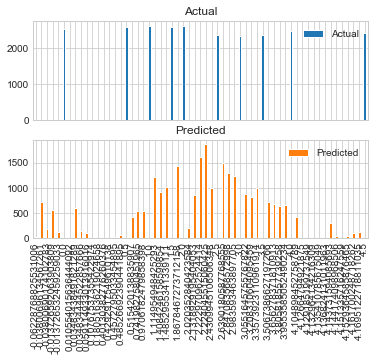

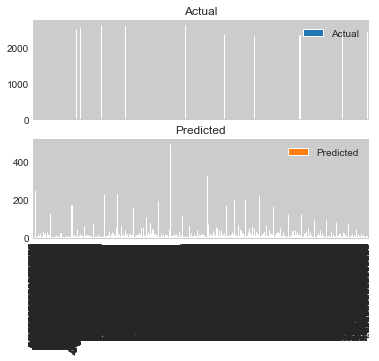

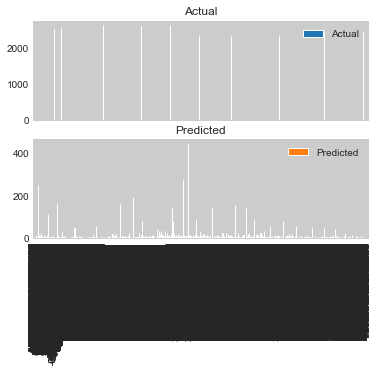

In [54]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim =1
    else:
        trainX_data = combination_features_X 
        dim = 2
    result = compute_MLP_Regressor(flag=1,dim=dim,trainX_data=trainX_data,trainY_data=train_Y,
                                   testX_data=trainX_data,testY_data=train_Y,
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Experiment - Validation_split

Train on 17383 samples, validate on 7451 samples
Epoch 1/50
17383/17383 [==============================] - 3s 175us/step - loss: 1.0145 - accuracy: 0.1856 - mean_absolute_error: 0.8058 - val_loss: 3.0466 - val_accuracy: 9.3947e-04 - val_mean_absolute_error: 1.6842
Epoch 2/50
17383/17383 [==============================] - 3s 157us/step - loss: 0.6659 - accuracy: 0.2517 - mean_absolute_error: 0.6687 - val_loss: 3.0231 - val_accuracy: 0.0011 - val_mean_absolute_error: 1.6712
Epoch 3/50
17383/17383 [==============================] - 3s 164us/step - loss: 0.5766 - accuracy: 0.2903 - mean_absolute_error: 0.6162 - val_loss: 2.6821 - val_accuracy: 0.0044 - val_mean_absolute_error: 1.5543
Epoch 4/50
17383/17383 [==============================] - 3s 168us/step - loss: 0.5348 - accuracy: 0.3018 - mean_absolute_error: 0.5972 - val_loss: 3.3369 - val_accuracy: 1.3421e-04 - val_mean_absolute_error: 1.7629
Epoch 5/50
17383/17383 [==============================] - 3s 182us/step - loss: 0.5085 - accura

<Figure size 864x432 with 0 Axes>

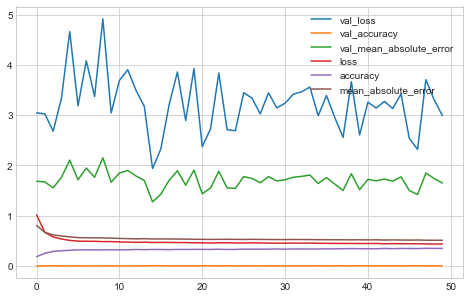

24834/24834 [==============================] - 0s 18us/step


[1.1896135048613612, 0.24285253882408142, 0.8499979972839355]

In [55]:
model = create_model(dim=2)
history = model.fit(combination_features_X,train_Y,validation_split=0.3,batch_size = 10,epochs=50,verbose=1)
plt.figure(figsize=(12,6))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
model.evaluate(combination_features_X,train_Y,verbose=1)

#### Experiment -MLP with Stratified K-Fold
Experiment using cross validation approach of StratifiedKFold

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X 
        dim = 2
    for cv in cross_validation_list:
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(trainX_data,default_groups)
        result = compute_MLP_Regressor(testX_data=trainX_data,dim=dim,testY_data=train_Y.ravel(),epochs=25,
                                   scaler=StandardScaler(),cross_validation=splited)
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000002ABD90867C8>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000002ABBC9C9B48>
Cross Validation Activated. CV = <generator object _BaseKFold.split at 0x000002ABBC375548>


#### Experiment - MLP with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim =1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = size, random_state = 42,stratify=default_groups)
        result = compute_MLP_Regressor(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                       scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Experiment - MLP with Leave One Group Out
Experiment using cross validation approach of Leave One Group Out

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    result = compute_MLP_Regressor(testX_data=trainX_data,testY_data=train_Y,dim=dim,epochs=25,scaler=StandardScaler(),cross_validation = splited)
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using MLP

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
    holdout = compute_MLP_Regressor(verbose=1,dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    loo = compute_MLP_Regressor(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups)
    skfold = compute_MLP_Regressor(testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
            loo = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=cv)
            splited = skf.split(train_X_rssi,default_groups,default_groups)
            result = compute_MLP_Regressor(flag = 0,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = selected_fold)  
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.4, random_state = 6,stratify=default_groups)
            result = compute_MLP_Regressor(dim=dim,epochs=25,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### Run RandomSearchCV for parameter tunning

In [ ]:
score = 'neg_mean_absolute_error'
scaler = StandardScaler()
scaler.fit(train_X_rolling_mean)
tr = scaler.transform(train_X_rolling_mean)
model = KerasRegressor(build_fn=create_model,dim=1,epochs=50,batch_size=10,verbose=0)
param_grid = dict(activation=activation,optimizer=optimizer,num_neurons=neurons)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=6).split(trainX_data,default_groups,default_groups),
                          scoring=score,random_state=42)
display(grid)
grid_result = grid.fit(tr.reshape(-1,1), train_Y.reshape(-1,1))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


### Best Results
Compute MLP with the best parameters

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
dim = 2
selected_method = 'HoldOut'
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
        dim = 1
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        dim = 1
    else:
        trainX_data = combination_features_X
        dim = 2
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
        loo = compute_MLP_Regressor(flag = 0,verbose=1,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited) 
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(train_X_rssi,default_groups,default_groups)
        result = compute_MLP_Regressor(flag = 0,verbose=1,testX_data=trainX_data,dim=dim,epochs=25,testY_data=train_Y,scaler=StandardScaler(),cross_validation = selected_fold)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.4, random_state = 6,stratify=default_groups)
        result = compute_MLP_Regressor(dim=dim,epochs=25,verbose=1,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))